# Movie recommendation database

In [2]:
import numpy as np 
import pandas as pd 
import string
import psycopg2
import config
from sqlalchemy import create_engine
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline

### Extract data from movies_metadata.csv, ratings_small.csv and links.csv into pandas dataframes

In [2]:
# Extract data from movies_metadata.csv
movies_metadata_df = pd.read_csv('Resources/movies_metadata.csv')
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Extract data from ratings_small.csv
ratings_small_df = pd.read_csv('Resources/ratings_small.csv')
#ratings_small_df.head()
ratings_small_df.shape

(100004, 4)

In [4]:
# Extract data from links_small.csv
links_small_df = pd.read_csv('Resources/links_small.csv')
links_small_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Clean data and transform it 

##### Cleaning movies_metadata dataframe

In [5]:
# Create a new movies dataframe without the genre column
movies_df = movies_metadata_df[["id", "imdb_id","title","release_date","budget", "revenue" ,"vote_average"]]
movies_df.head()

# Remove the rows with null values
movies_df = movies_df.dropna()
movies_df.shape

# Remove all duplicate rows
movies_df = movies_df.drop_duplicates()
movies_df.shape

# Change the type of id to int
movies_df["id"] =movies_df["id"].astype(int)
movies_df.head()
# Slice first 3 characters of imdb_id to get it in the format of links dataframe
movies_df["imdb_id"] = movies_df["imdb_id"].str[2:]
movies_df.head()

,id,imdb_id,title,release_date,budget,revenue,vote_average
0,862,0114709,Toy Story,10/30/1995,30000000,373554033.0,7.7
1,8844,0113497,Jumanji,12/15/1995,65000000,262797249.0,6.9
2,15602,0113228,Grumpier Old Men,12/22/1995,0,0.0,6.5
3,31357,0114885,Waiting to Exhale,12/22/1995,16000000,81452156.0,6.1
4,11862,0113041,Father of the Bride Part II,2/10/1995,0,76578911.0,5.7


In [6]:
# Create new movies dataframe with genre column
movies_genre_df = movies_metadata_df[["id", "imdb_id","genres","title","release_date","budget", "revenue" ,"vote_average"]]
#movies_df.head()
movies_genre_df.shape

(45463, 8)

In [7]:
# Remove the rows with null values
movies_genre_df = movies_genre_df.dropna()
movies_genre_df.shape


(45362, 8)

In [8]:
# Remove all duplicate rows
movies_genre_df = movies_genre_df.drop_duplicates()
movies_genre_df.shape

(45332, 8)

In [9]:
# Change the type of id to int
movies_genre_df["id"] =movies_genre_df["id"].astype(int)
movies_genre_df.head()

,id,imdb_id,genres,title,release_date,budget,revenue,vote_average
0,862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,10/30/1995,30000000,373554033.0,7.7
1,8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,12/15/1995,65000000,262797249.0,6.9
2,15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,12/22/1995,0,0.0,6.5
3,31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,12/22/1995,16000000,81452156.0,6.1
4,11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,2/10/1995,0,76578911.0,5.7


In [10]:
# Slice first 2 characters of imdb_id to get it in the format of links dataframe
movies_genre_df["imdb_id"] = movies_genre_df["imdb_id"].str[2:]
movies_genre_df.head(10)

,id,imdb_id,genres,title,release_date,budget,revenue,vote_average
0,862,0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,10/30/1995,30000000,373554033.0,7.7
1,8844,0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,12/15/1995,65000000,262797249.0,6.9
2,15602,0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,12/22/1995,0,0.0,6.5
3,31357,0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,12/22/1995,16000000,81452156.0,6.1
4,11862,0113041,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,2/10/1995,0,76578911.0,5.7
5,949,0113277,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat,12/15/1995,60000000,187436818.0,7.7
6,11860,0114319,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Sabrina,12/15/1995,58000000,0.0,6.2
7,45325,0112302,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Tom and Huck,12/22/1995,0,0.0,5.4
8,9091,0114576,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Sudden Death,12/22/1995,35000000,64350171.0,5.5
9,710,0113189,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",GoldenEye,11/16/1995,58000000,352194034.0,6.6


In [39]:
# The genres column is string, so transform the genres column into json so that we can reference as a list.
# First replace all single quote to double quote to satisfy json format.
movies_genre_df['genres'] = movies_genre_df['genres'].str.replace("'",'"')

# Create an empty list to store json result:
genre_list_name = []
genre_list_temp = []
genre_list_id = []
# Load each row into json format, and store into the list:
for index, row in movies_genre_df.iterrows():
    genre_list_temp = json.loads(row['genres'])
    for item in genre_list_temp:
        genre_list_name.append(item['name'])
        genre_list_id.append(row['id'])
    # create list of dictionaries with the genre name and movie id
genre_list_dict = []
for i in range(len(genre_list_name)):
    genre_list_dict.append({'movie_id': genre_list_id[i],'genre': genre_list_name[i] })
# create a dataframe from the list of dictionaries
genre_list_df = pd.DataFrame(genre_list_dict)
genre_list_df.head()
genre_list_df.reset_index(inplace=True)
genre_list_df = genre_list_df.rename(columns = {'index':'genreId'})
genre_list_df.dropna(inplace=True)
genre_list_df.drop_duplicates()
genre_list_df.head()

,genreId,movie_id,genre
0,0,862,Animation
1,1,862,Comedy
2,2,862,Family
3,3,8844,Adventure
4,4,8844,Fantasy


##### Cleaning ratings dataframe

In [12]:
# Create a new dataframe for ratings with only the columns we need
ratings_df = ratings_small_df[["userId", "movieId", "rating"]]
#ratings_df.head()
ratings_df.shape

(100004, 3)

In [13]:
# Remove the rows with null values
ratings_df = ratings_df.dropna()
ratings_df.shape

(100004, 3)

In [14]:
# Remove all duplicate rows
ratings_df = ratings_df.drop_duplicates()
ratings_df.shape

(100004, 3)

In [15]:
# datatype of movieId
ratings_df['movieId'].astype(int)
ratings_df['movieId'].dtype

dtype('int64')

In [16]:
movies_df['id'].astype(int)
movies_df['id'].dtype

dtype('int32')

In [17]:
ratings_df

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


##### Cleaning links dataframe

In [18]:
# Create a new dataframe for links with only the columns we need
links_df = links_small_df[["movieId", "imdbId", "tmdbId"]]
# Drop the rows with null values
links_df.dropna(inplace=True)
# Change the tmdbId to int in the links dataframe
links_df["tmdbId"] = links_df["tmdbId"].apply(np.int64)
links_df

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862
...,...,...,...
9120,162672,3859980,402672
9121,163056,4262980,315011
9122,163949,2531318,391698
9123,164977,27660,137608


### Connect to local database

In [3]:
# Connect to your Postgres database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(config.username, config.password, 'localhost', 5432, 'movies_db'))
con = engine.connect()

In [109]:
# check for tablenames in the database
engine.table_names()

C:\Users\vasan\AppData\Local\Temp/ipykernel_4872/3623636692.py:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['movies', 'genre', 'ratings', 'links']

In [82]:
# use pandas to load  movies csv converted into dataframe into the database
movies_df.to_sql('movies', con, if_exists='replace', index=False)

In [84]:
# confirm that the data was loaded into the movies table
pd.read_sql_query('select * from movies', con=engine).head()

,id,imdb_id,title,release_date,budget,revenue,vote_average
0,862,0114709,Toy Story,10/30/1995,30000000,373554033.0,7.7
1,8844,0113497,Jumanji,12/15/1995,65000000,262797249.0,6.9
2,15602,0113228,Grumpier Old Men,12/22/1995,0,0.0,6.5
3,31357,0114885,Waiting to Exhale,12/22/1995,16000000,81452156.0,6.1
4,11862,0113041,Father of the Bride Part II,2/10/1995,0,76578911.0,5.7


In [85]:
# use pandas to load genre csv converted into dataframe into the database
genre_list_df.to_sql('genre', con, if_exists='replace', index=False)

In [86]:
# confirm that the data was loaded into the genre table
pd.read_sql_query('select * from genre', con=engine).head()

,genreId,movie_id,genre
0,0,862,Animation
1,1,862,Comedy
2,2,862,Family
3,3,8844,Adventure
4,4,8844,Fantasy


In [87]:
# use pandas to load ratings csv converted into dataframe into the database
ratings_df.to_sql('ratings', con, if_exists='replace', index=False)

In [88]:
# confirm that the data was loaded into the ratings table
pd.read_sql_query('select * from ratings where rating = 5', con=engine).head()

,userId,movieId,rating
0,2,17,5.0
1,2,39,5.0
2,2,150,5.0
3,2,222,5.0
4,2,265,5.0


In [89]:
# use pandas to load small_links csv converted into dataframe into the links table
links_df.to_sql('links', con, if_exists='replace', index=False)

In [90]:
# confirm that the data was loaded into the links table
pd.read_sql_query('select * from links', con=engine).head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [55]:
# Query the database to get the movie titles and their genres
query = "select movies.title, genre.genre from movies join genre on movies.id = genre.movie_id"
pd.read_sql_query(query, con=engine).head(10)

,title,genre
0,Ariel,Crime
1,Ariel,Drama
2,Shadows in Paradise,Drama
3,Shadows in Paradise,Comedy
4,Four Rooms,Comedy
5,Four Rooms,Crime
6,Judgment Night,Thriller
7,Judgment Night,Action
8,Judgment Night,Crime
9,Star Wars,Science Fiction


In [56]:
# List all Comedy  movies
query = "select movies.title, genre.genre from movies join genre on movies.id = genre.movie_id where genre.genre = 'Comedy'"
pd.read_sql_query(query, con=engine).head(10)

,title,genre
0,Toy Story,Comedy
1,Grumpier Old Men,Comedy
2,Waiting to Exhale,Comedy
3,Father of the Bride Part II,Comedy
4,Sabrina,Comedy
5,The American President,Comedy
6,Dracula: Dead and Loving It,Comedy
7,Four Rooms,Comedy
8,Ace Ventura: When Nature Calls,Comedy
9,Money Train,Comedy


In [106]:
# List all movies with rating 5
query = "select movies.title from movies, ratings where (movies.id = ratings."'"movieId"'") and (ratings.rating =5)"
pd.read_sql_query(query, con=engine).head()

,title
0,The Dark
1,48 Hrs.
2,Berlin: Symphony of a Great City
3,Lili Marleen
4,Contempt


In [176]:
# List 10 Action movies with rating 5
query = "select movies.title from movies, ratings, genre where (genre.genre = 'Action') and (ratings.rating = 5) and (genre.movie_id = movies.id) and (ratings."'"movieId"'"=movies.id)\
group by movies.title order by movies.title"
pd.read_sql_query(query, con=engine).head(10)

,title
0,"20,000 Leagues Under the Sea"
1,300
2,48 Hrs.
3,5 Card Stud
4,A View to a Kill
5,Absolon
6,Aces Go Places V: The Terracotta Hit
7,Alexander
8,Alien
9,Aliens vs Predator: Requiem


In [194]:
# List movies with their rating and genres
query = "select ratings."'"userId"'",movies.title,ratings.rating, genre.genre from movies, ratings, genre where (genre.movie_id = movies.id) and (ratings."'"movieId"'"=movies.id) group by ratings."'"userId"'",movies.title, ratings.rating, genre.genre order by movies.title  "
pd.read_sql_query(query, con=engine)

,userId,title,rating,genre
0,15,'Gator Bait,0.5,Action
1,15,'Gator Bait,0.5,Thriller
2,73,'Twas the Night Before Christmas,4.5,Animation
3,73,'Twas the Night Before Christmas,4.5,Family
4,157,'Twas the Night Before Christmas,3.5,Animation
...,...,...,...,...
109754,505,Zombie Holocaust,2.5,Horror
109755,529,Zombie Holocaust,3.5,Horror
109756,547,Zombie Holocaust,3.5,Horror
109757,547,Zozo,3.5,Drama


Text(0.5, 0, 'Movie rating(0-5)')

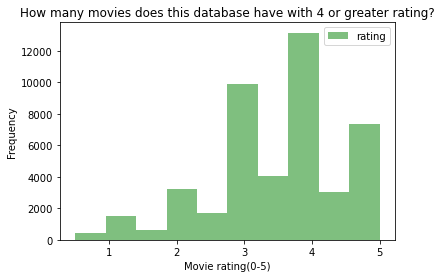

In [10]:
# Plot to see the database collection based on ratings to find number of movies in the collection with rating 4 or greater
query = "select movies.title, ratings.rating from movies, ratings where (movies.id = ratings."'"movieId"'")  order by  ratings.rating  "
rating_title_df = pd.read_sql_query(query, con=engine)
ax=rating_title_df.plot.hist(x='title', y='rating', color='g',alpha = 0.5, title ='How many movies does this database have with 4 or greater rating?'  )
ax.set_xlabel('Movie rating(0-5)')

<AxesSubplot:title={'center':'Plot showing the Movies, their genre and their ratings\n'}, xlabel='title', ylabel='genre'>

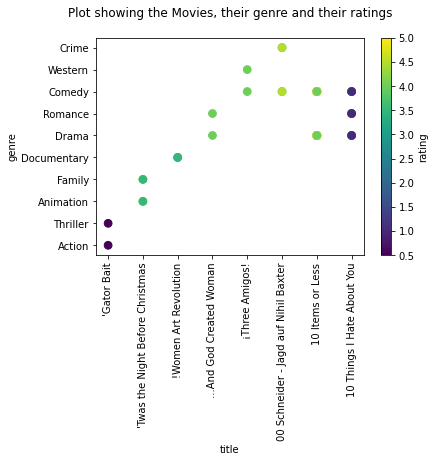

In [7]:
query = "select ratings."'"userId"'",movies.title,ratings.rating, genre.genre from movies, ratings, genre where (genre.movie_id = movies.id) and (ratings."'"movieId"'"=movies.id) group by ratings."'"userId"'",movies.title, ratings.rating, genre.genre order by movies.title limit 50   "
df = pd.read_sql_query(query, con=engine)
fig,ax = plt.subplots()
plt.xticks(np.arange(0, len(df['title'].to_list())))
df.plot.scatter(x='title', y='genre',title = 'Plot showing the Movies, their genre and their ratings\n', c='rating', colormap = 'viridis', rot=90, ax=ax,s=60)

In [195]:
# Identify the most profitable movies

In [ ]:
# Find the rating for the profitable movies